In [ ]:
import kagglehub

path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)
!cp -r "{path}" .

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = datasets.ImageFolder(root='3/train', transform=transform)
test_dataset = datasets.ImageFolder(root='3/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [3]:
num_epochs = 2
train_losses = []
eval_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    eval_accuracies.append(accuracy)
    print(f'Accuracy on test data: {accuracy:.2f}%')

import pickle

metrics = {
    'train_losses': train_losses,
    'eval_accuracies': eval_accuracies,
    'classes': train_dataset.classes,
    'class_counts': [0] * len(train_dataset.classes),
    'samples': [train_dataset[i] for i in range(4)]
}

for _, label in train_dataset.samples:
    metrics['class_counts'][label] += 1

with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("Training complete. Metrics saved for later visualization.")

Epoch [1/2], Loss: 0.0289
Accuracy on test data: 94.50%
Epoch [2/2], Loss: 0.0248
Accuracy on test data: 94.86%
Training complete. Metrics saved for later visualization.


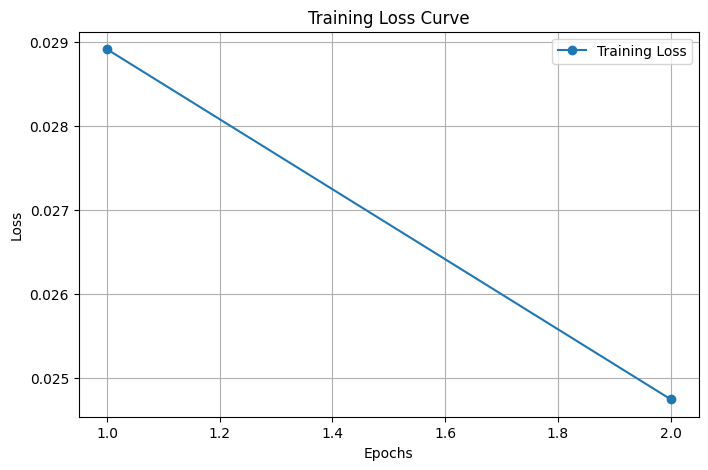

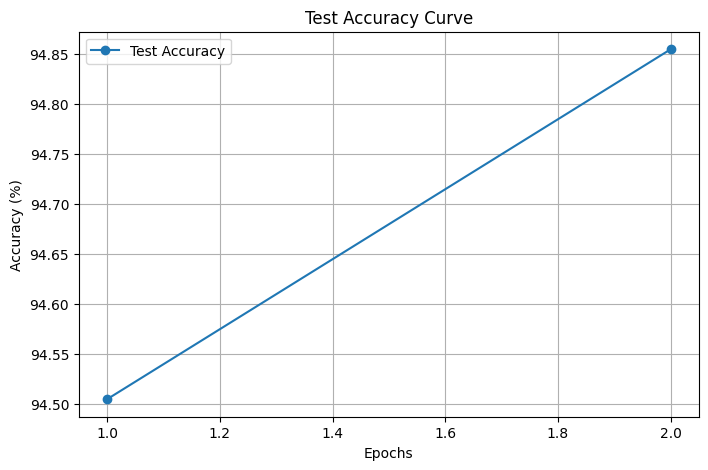

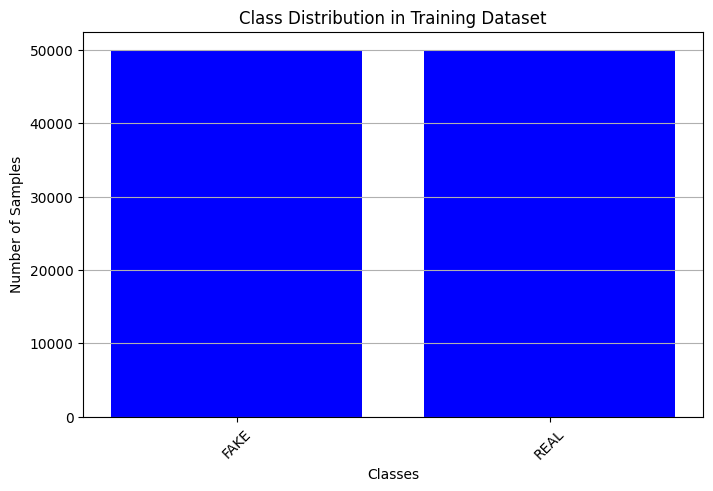

Sample Images from the Dataset:


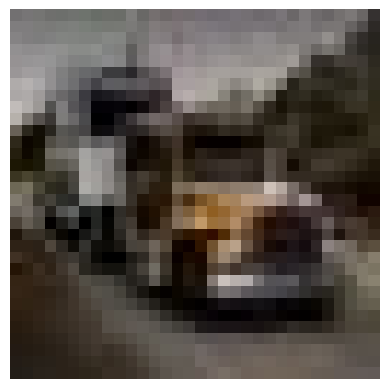

Class: FAKE


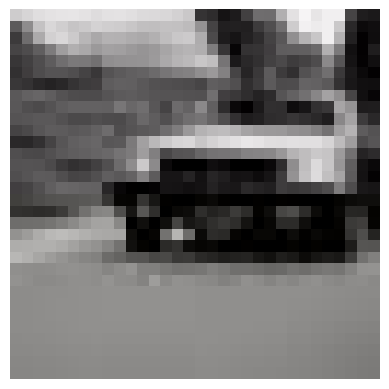

Class: FAKE


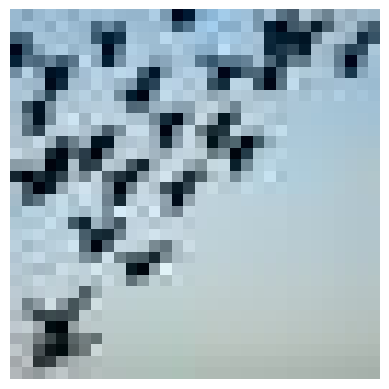

Class: FAKE


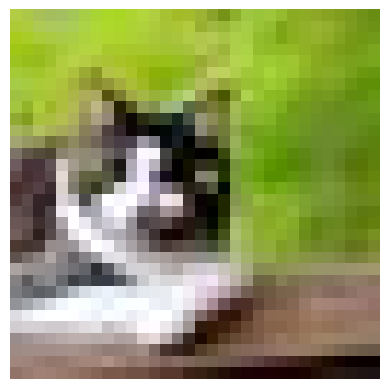

Class: FAKE


In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torchvision

with open('metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

train_losses = metrics['train_losses']
eval_accuracies = metrics['eval_accuracies']
classes = metrics['classes']
class_counts = metrics['class_counts']
samples = metrics['samples']

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(classes, class_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

print("Sample Images from the Dataset:")
for sample, label in samples:
    imshow(sample)
    print(f"Class: {classes[label]}")

Upscaled Images with Predictions:


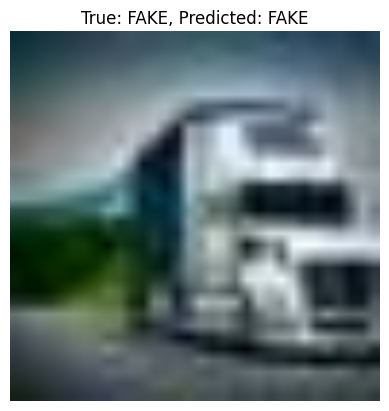

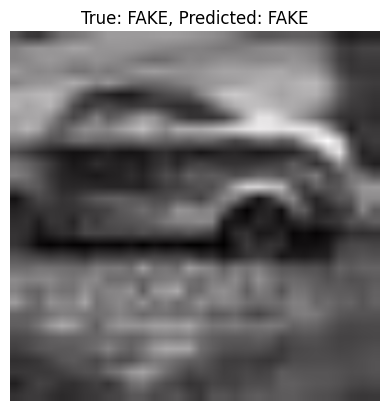

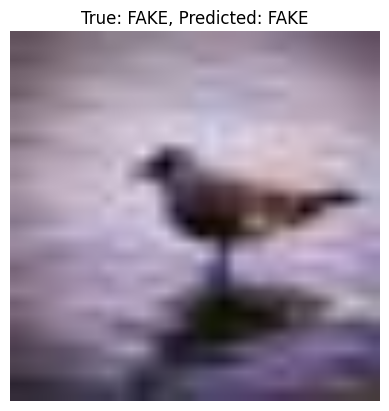

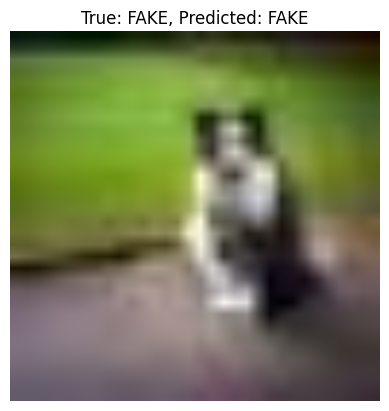

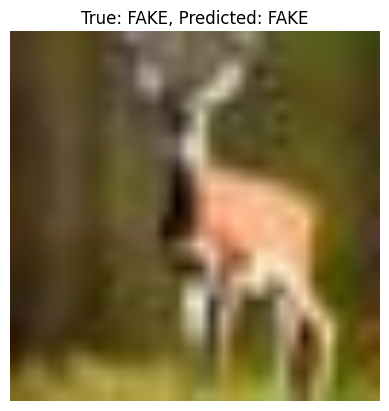

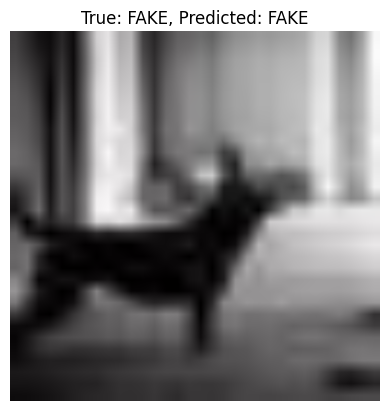

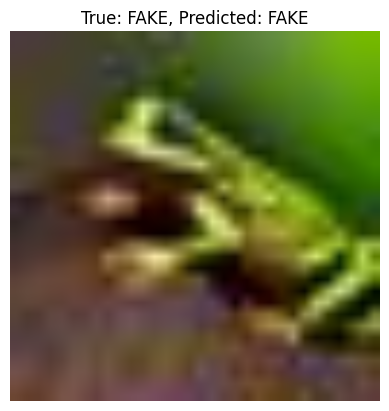

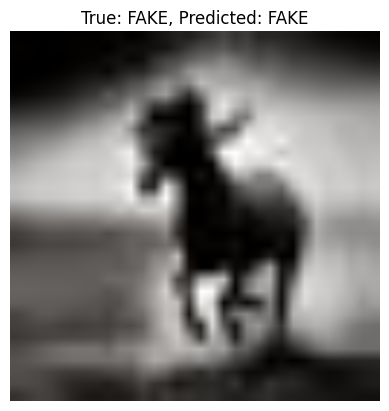

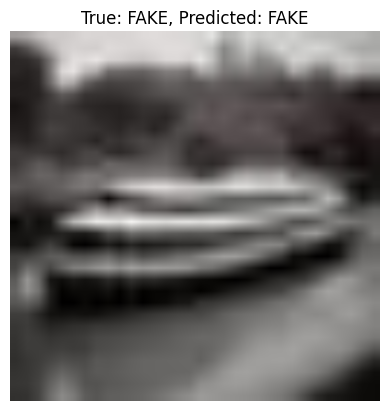

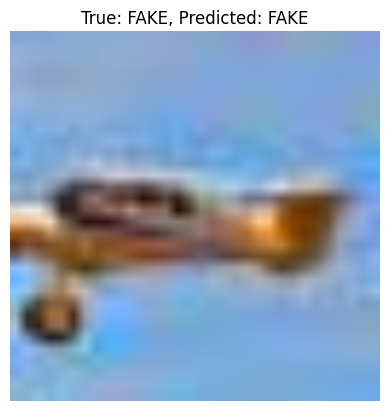

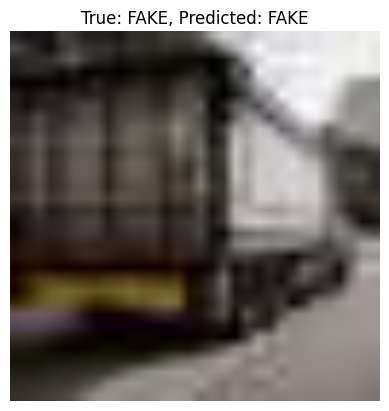

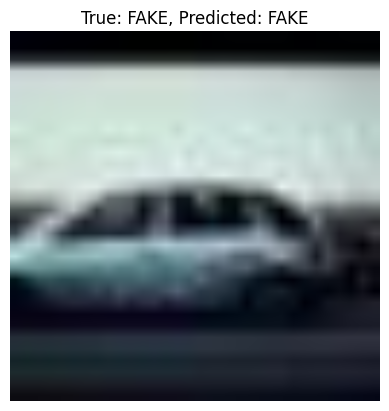

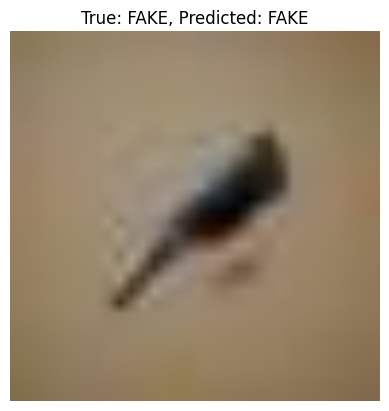

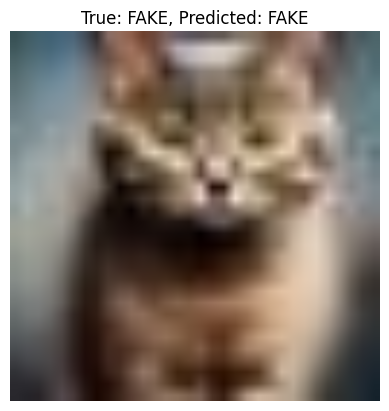

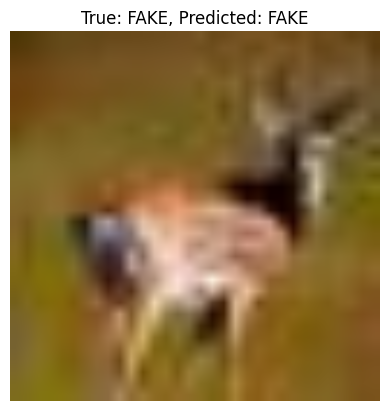

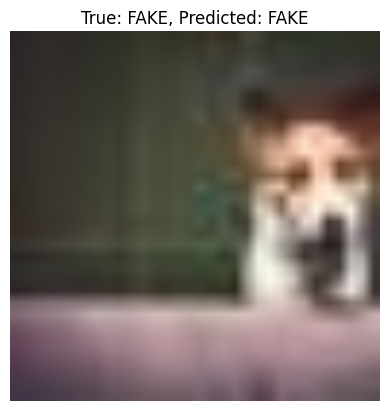

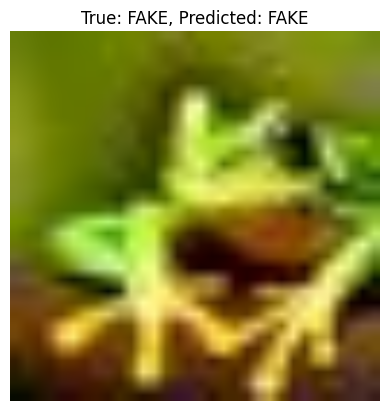

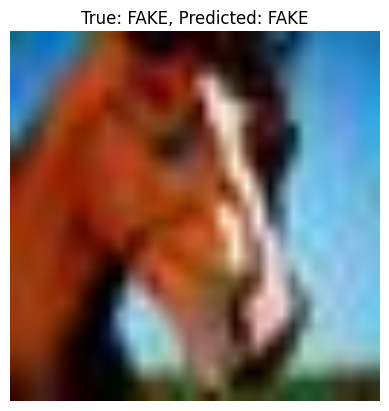

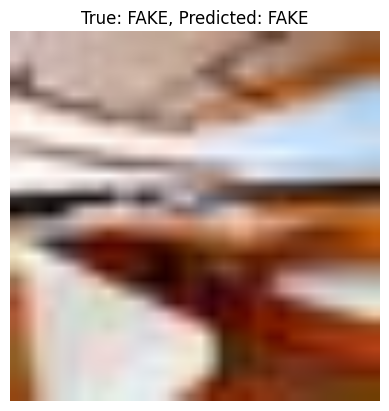

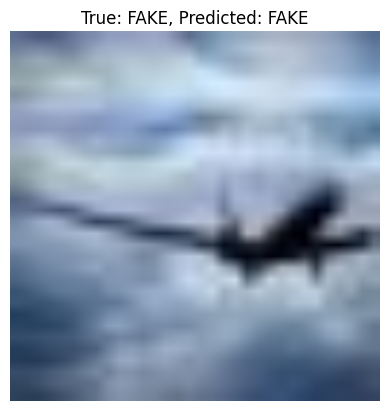

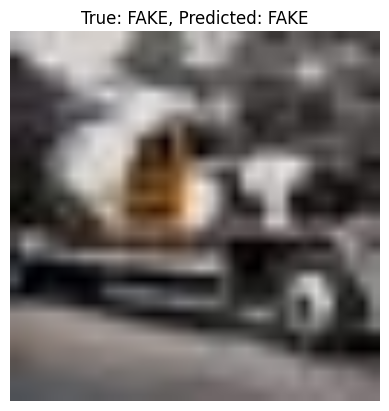

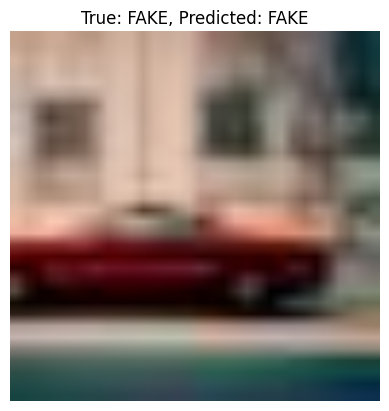

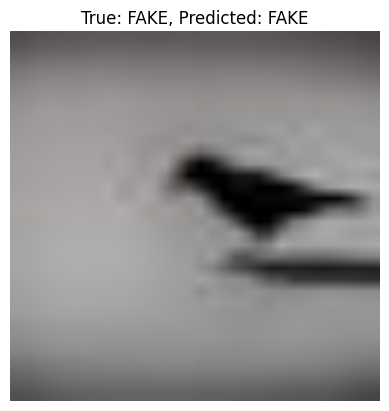

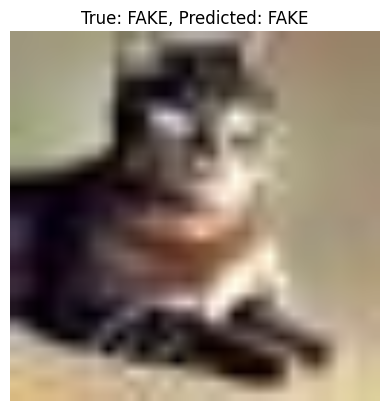

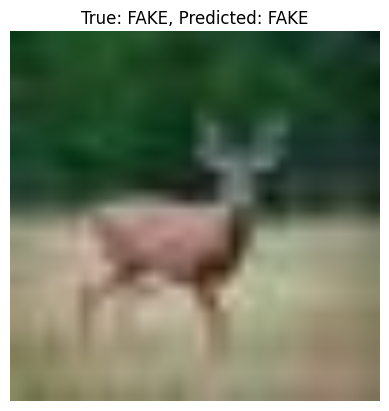

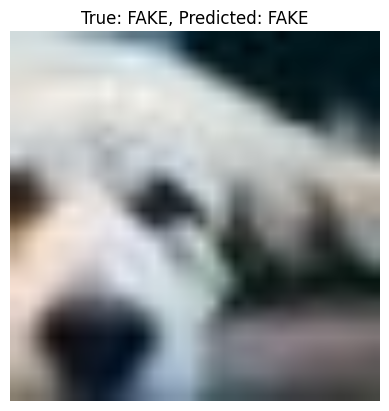

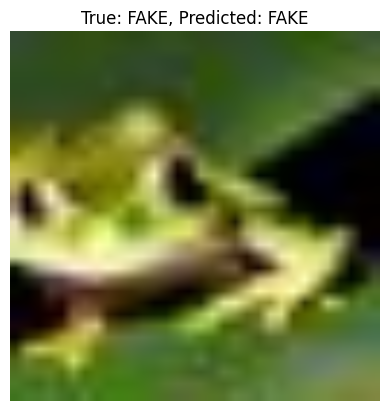

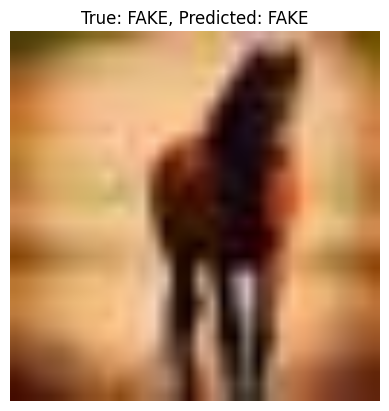

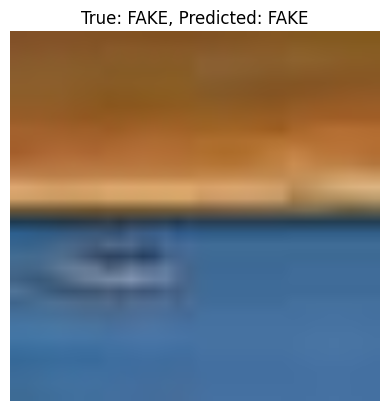

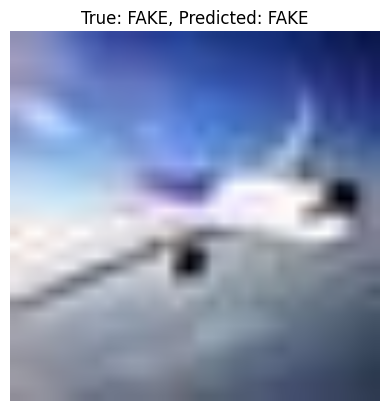

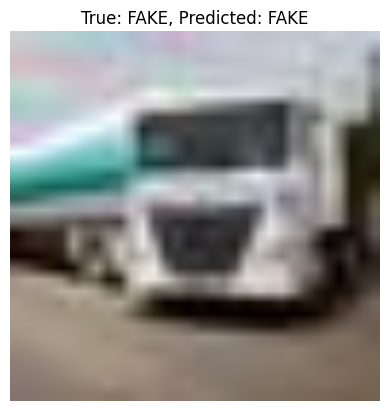

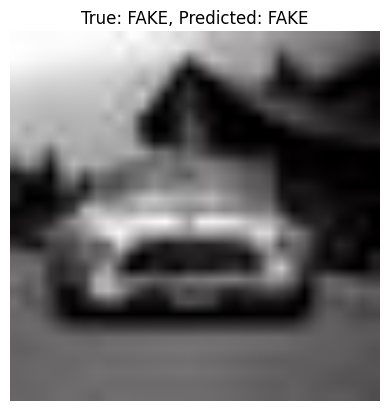

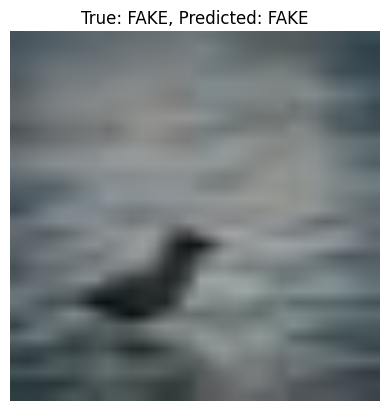

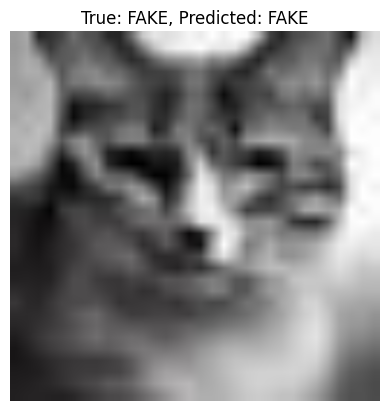

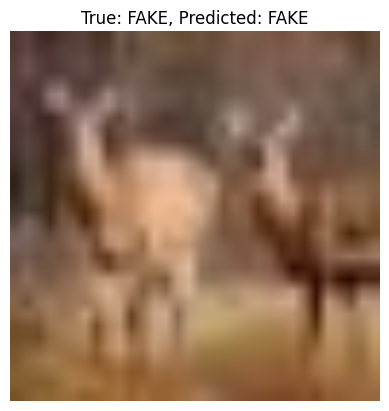

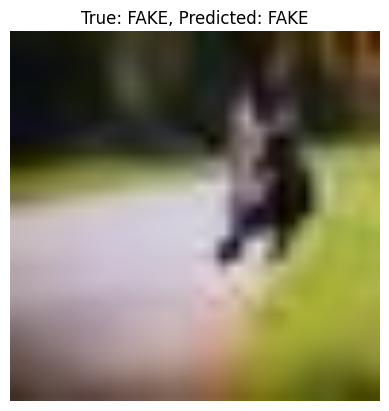

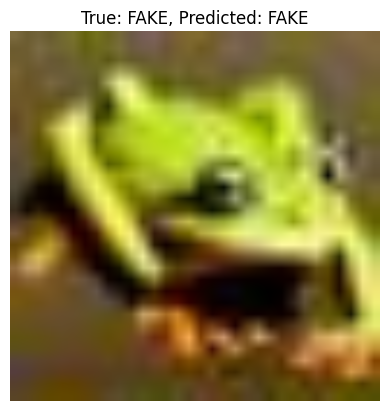

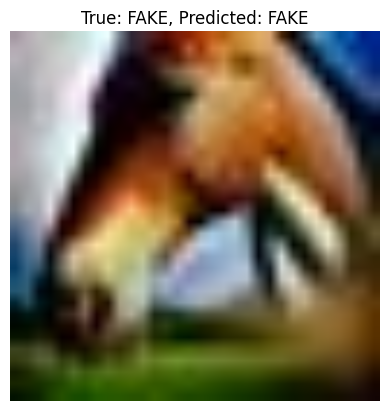

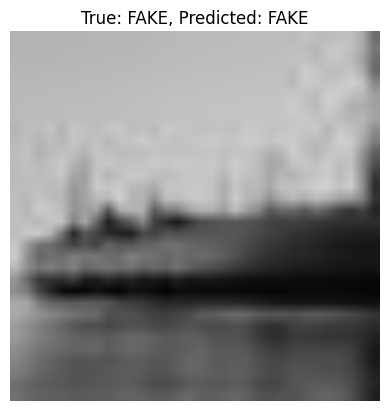

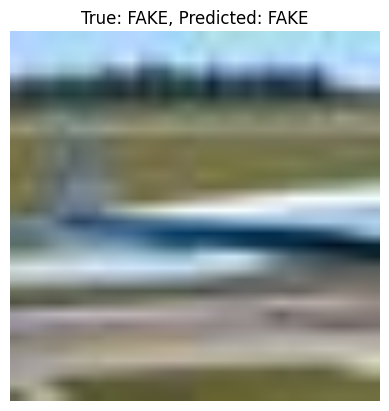

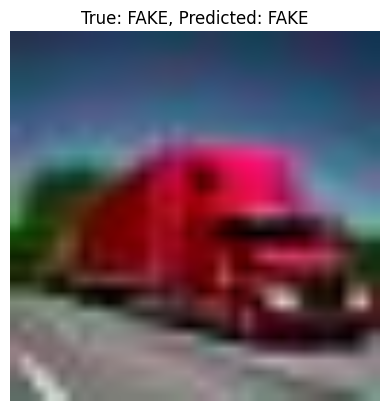

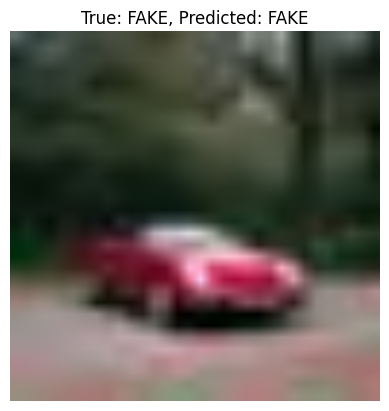

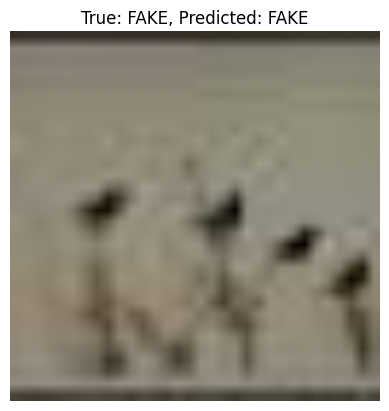

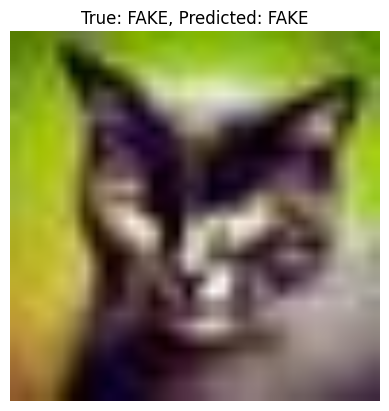

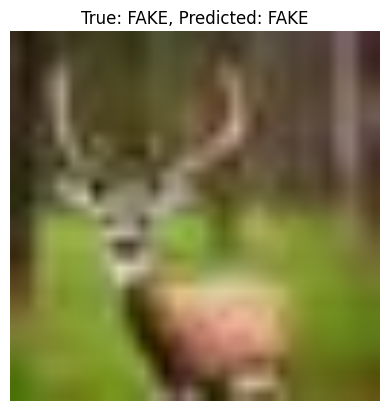

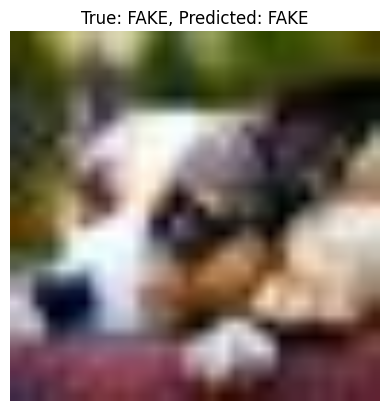

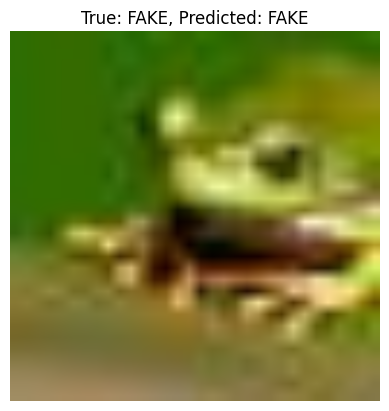

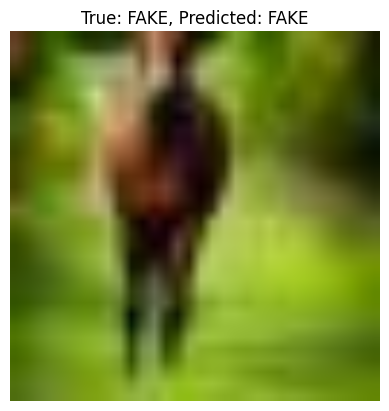

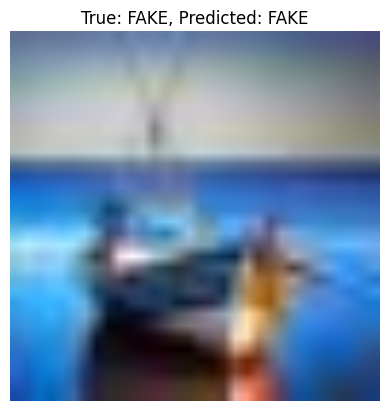

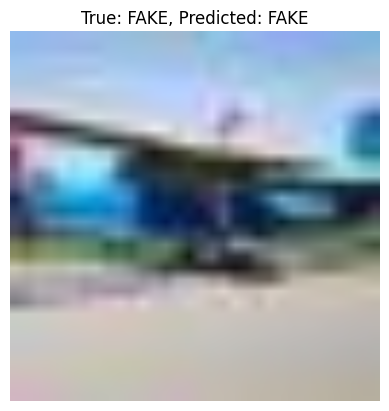

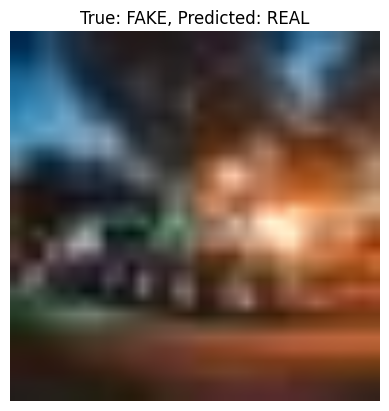

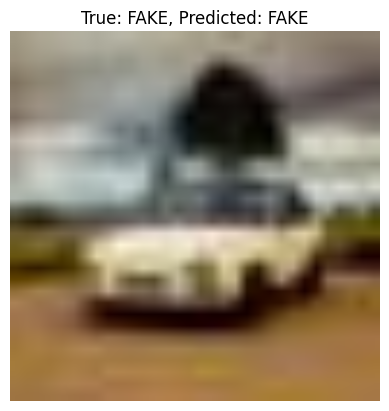

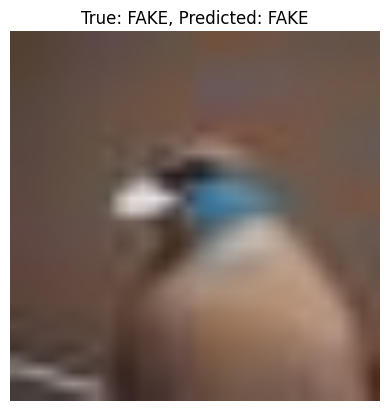

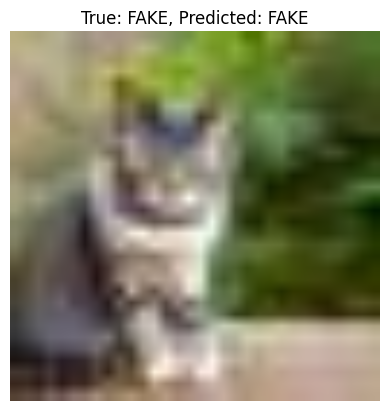

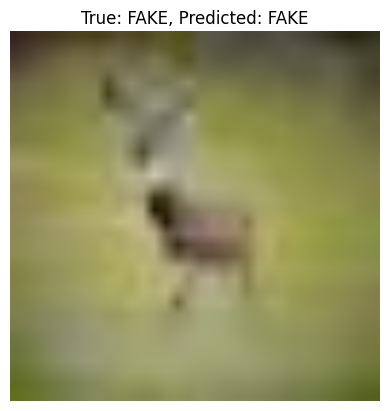

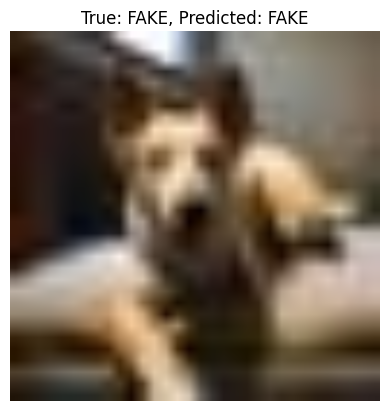

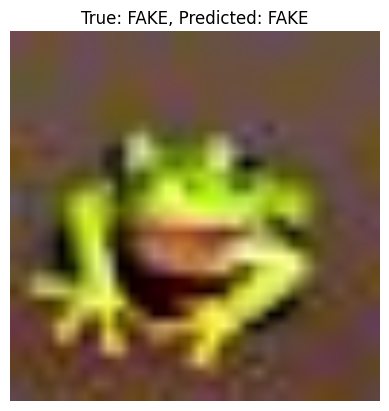

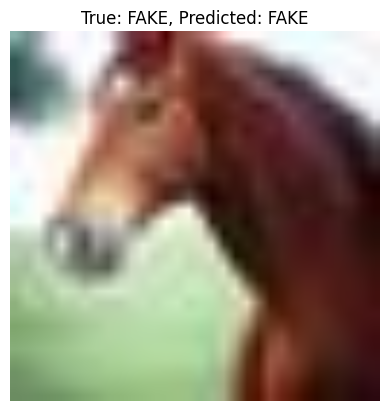

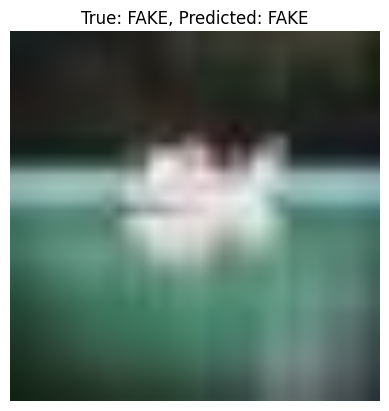

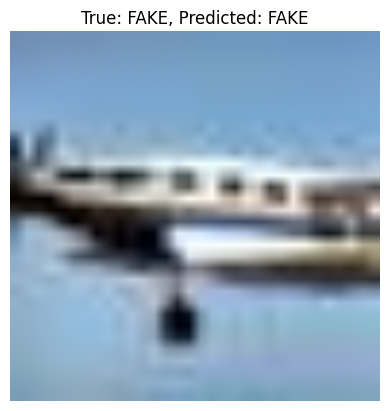

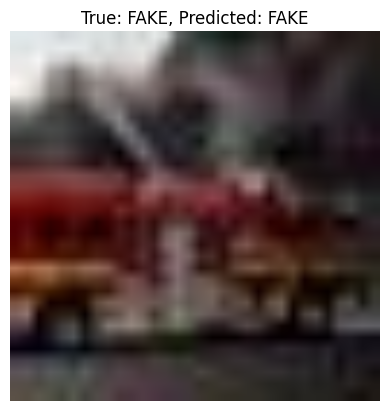

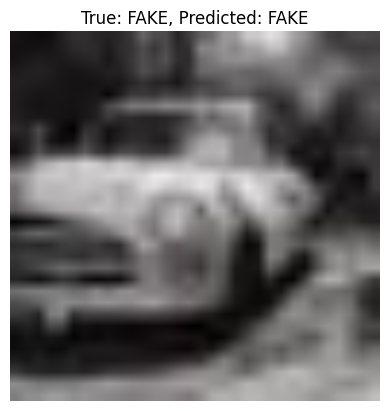

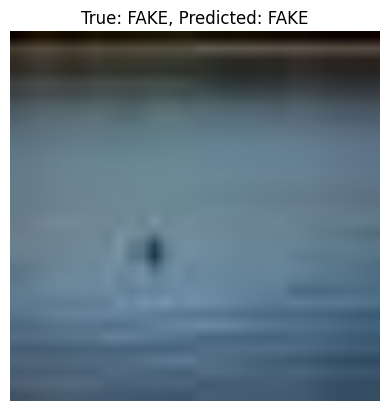

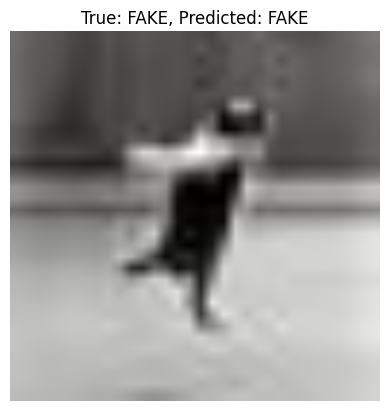

In [12]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np

def upscale_and_show(image, true_label, predicted_label=None, upscale_size=(1024, 1024)):
    """
    Upscales and visualizes the image with true and predicted labels.
    """
    image = image.cpu()
    upscaled_image = TF.resize(image, upscale_size)

    img = upscaled_image / 2 + 0.5
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    title = f"True: {true_label}"
    if predicted_label is not None:
        title += f", Predicted: {predicted_label}"
    plt.title(title)
    plt.axis('off')
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

print("Upscaled Images with Predictions:")
for i in range(len(images)):
    upscale_and_show(images[i],
                     true_label=metrics['classes'][labels[i]],
                     predicted_label=metrics['classes'][predicted[i]])
